In [1]:
import numpy as np
import tensorflow as tf
from sopt.optimizers.tensorflow.utils import BackTrackingLineSearch, AdaptiveLineSearch
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [75]:
tf.reset_default_graph()

In [76]:
lossfn = lambda x: tf.reduce_sum((x - 2)**2) 
def obj_and_upd_fn(x, y): 
    fnval = lossfn(x + y)
    return fnval, x + y

In [80]:
inits = np.random.randn(100).astype('float32') * 20
v1 = tf.Variable(inits)
v2 = tf.Variable(inits)
bls_steps = tf.Variable(0, dtype='int32')
als_steps = tf.Variable(0, dtype='int32')

In [81]:
loss_t1 = lossfn(v1)
loss_t2 = lossfn(v2)
mean_v1 = tf.reduce_mean(v1)
mean_v2 = tf.reduce_mean(v2)

In [82]:
grad1 = tf.gradients(loss_t1, v1)[0]
grad2 = tf.gradients(loss_t2, v2)[0]

In [83]:
bls = BackTrackingLineSearch()
als = AdaptiveLineSearch()

In [84]:
bls_out = bls.search(obj_and_upd_fn, v1, -grad1, grad1)
als_out = als.search(obj_and_upd_fn, v2, -grad2, grad2)

In [85]:
assign_op1  = tf.group([v1.assign(bls_out.newx), bls_steps.assign_add(bls_out.step_count)])
assign_op2 = tf.group([v2.assign(als_out.newx), als_steps.assign_add(als_out.step_count)])

In [86]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [87]:
bls_alphas = []
bls_steps_all = []
bls_lossvals = []
bls_meanvals = []
als_alphas = []
als_steps_all = []
als_lossvals = []
als_meanvals = []
for i in range(10):
    sess.run([assign_op1, assign_op2])
    stepb, lossb, meanb, alphab = sess.run([bls_steps, loss_t1, mean_v1, bls._alpha])
    stepa, lossa, meana, alphaa = sess.run([als_steps, loss_t2, mean_v2, als._alpha]) 
    
    bls_steps_all.append(stepb)
    bls_lossvals.append(lossb)
    bls_meanvals.append(meanb)
    bls_alphas.append(alphab)
    
    als_steps_all.append(stepa)
    als_lossvals.append(lossa)
    als_meanvals.append(meana)
    als_alphas.append(alphaa)
    

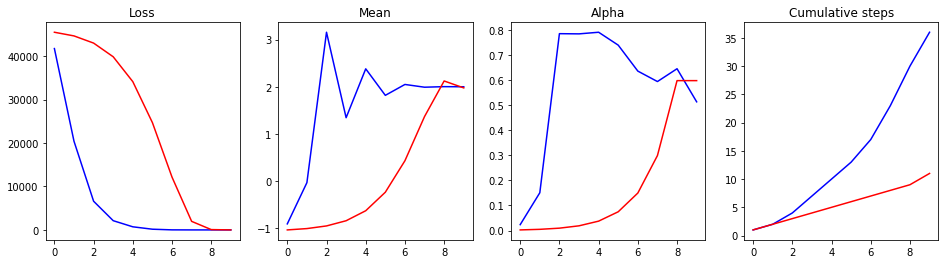

In [93]:
# Final mean should be 2.0

plt.figure(figsize=[16,4])
plt.subplot(1, 4, 1)
plt.plot(bls_lossvals, color='blue')
plt.plot(als_lossvals, color='red')
plt.title('Loss')
plt.subplot(1,4,2)
plt.plot(bls_meanvals, color='blue')
plt.plot(als_meanvals, color='red')
plt.title('Mean')
plt.subplot(1,4,3)
plt.plot(bls_alphas, color='blue')
plt.plot(als_alphas, color='red')
plt.title('Alpha')
plt.subplot(1,4,4)
plt.plot(bls_steps_all, color='blue')
plt.plot(als_steps_all, color='red')
plt.title('Cumulative steps')
plt.show()

In [89]:
bls_alphas

[0.023331955,
 0.15043812,
 0.7844512,
 0.78365934,
 0.7901373,
 0.7386897,
 0.6352613,
 0.5936473,
 0.64469236,
 0.5128697]

In [30]:
als_lossvals

[44446.426,
 44025.78,
 43194.426,
 41570.902,
 38475.82,
 32857.344,
 23639.777,
 11465.578,
 1769.5519,
 81.2563]

In [31]:
bls_lossvals

[39329.914,
 35463.56,
 21684.229,
 1591.4303,
 532.0447,
 522.67865,
 485.88593,
 349.85922,
 17.303373,
 0.70043653]